This code is written by Kuba Jerzmanowski
This code is inspired and based on strongly from Andrej Karpathy Micro Grad Video

In [98]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [99]:
class Scalar:
    def __init__(self, data, _children=(), _op=''): 
        self.data = data
        self.grad = 0
        self.op = _op
        self._backward = lambda: None
        self._prev = set(_children)
    
    def __repr__(self):
        return f'Scalar(data={self.data})'
    
    def __add__(self, other):  #define add and the back prob for it 
        other = other if isinstance(other, Scalar) else Scalar(other) #this helps so we can pass in raw numbers
        out = Scalar(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other): #so the sum() works
        return self + other
    
    def __mul__(self, other): #define multiplication and the back prob for it 
        other = other if isinstance(other, Scalar) else Scalar(other)
        out = Scalar(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self): 
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    
    def __truediv__(self, other):
        return self * (other**-1)
    
    def __rmul__(self, other):
        return self * other
    

    def __pow__(self, other):
        out = Scalar(self.data ** other, (self, ), f'^{other}')

        def _backward():
            self.grad += out.grad * other * (self.data**(other-1))
        out._backward = _backward
        return out
 
    def tanh(self):
        t = (math.exp(2*self.data)-1)/(math.exp(2*self.data) + 1)
        out = Scalar(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward
        return out
    

    def sigmoid(self):
        s = 1 / (1 + np.exp(-self.data))
        out = Scalar(s, (self,), 'sigmoid')

        def _backward():
            self.grad += s * (1 - s) * out.grad
        out._backward = _backward

        return out
    
    def backprop(self): #we first build up the topo list then reverse it since we backprop in reverse starting with the Scalar representing the Loss
        self.grad = 1

        chain = []
        seen = set()
        def build_list(node):
            if node not in seen:
                seen.add(node)
                for par in node._prev:
                    build_list(par)
                chain.append(node)

        build_list(self)
        for node in reversed(chain):
            node.grad
            node._backward()

Define the NN 

In [100]:
from typing import Any


class Neuron:
    def __init__(self, width):
        #each neuron has weights to where they are the input width and an additional bias
        self.w = [Scalar(random.uniform(-1,1)) for _ in range(width+1)]
        self.b = Scalar(random.uniform(-1,1))

    def __call__(self, x):
        #here we want to miltiply so we will zip the weights to do wx+b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        return act.sigmoid()
    
    def params(self): #this function is nesscary so that we can later update each param after getting the grad
        return self.w + [self.b]
    
class Layer: #here we just move up another layer of abstraction where we will 
    def __init__(self, num_in, num_out):
        self.neurons = [Neuron(num_in) for _ in range(num_out)]

    def __call__(self, x):
        return [n(x) for n in self.neurons]
    
    def params(self):
        params = []
        for n in self.neurons:
            p = n.params()
            params.extend(p)
        return params
    
class MLP: 
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def params(self):
        params = []
        for l in self.layers:
            p = l.params()
            params.extend(p)
        return params
    
    def optim(self):
        for param in self.params():
           param.data += -0.01 * param.grad



Define the loss function. We have to double unpack because y is 2 outputs

In [101]:
def MSE(y_pred, y_true):
    def single_mse(pl, tl):
        return sum([(p-t)**2 for p, t in zip(pl, tl)])

    losses = [single_mse(pl, tl) for pl, tl in zip(y_pred, y_true)]
    data_loss = sum(losses) * (1.0 / len(losses))
    return data_loss


Def the Data

In [102]:
X = [
    [-1.0],
    [-0.9],
    [-0.8],
    [-0.7],
    [-0.6],
    [-0.5],
    [-0.4],
    [-0.3],
    [-0.2],
    [-0.1],
    [0],
    [0.1],
    [0.2],
    [0.3],
    [0.4],
    [0.5],
    [0.6],
    [0.7],
    [0.8],
    [0.9],
    [1.0]
]

Y = [
    [-0.96],
    [-0.577],
    [-0.073],
    [0.377],
    [0.641],
    [0.66],
    [0.461],
    [0.134],
    [-0.201],
    [-0.434],
    [-0.5],
    [-0.393],
    [-0.165],
    [0.099],
    [0.307],
    [0.396],
    [0.345],
    [0.182],
    [-0.031],
    [-0.219],
    [-0.321]
]

nn = MLP(1, [64,64,32,1])
lossi = [] #accumulate the loss

Train Looop

In [103]:
Y_plot = [nn(x)[0].data for x in X]

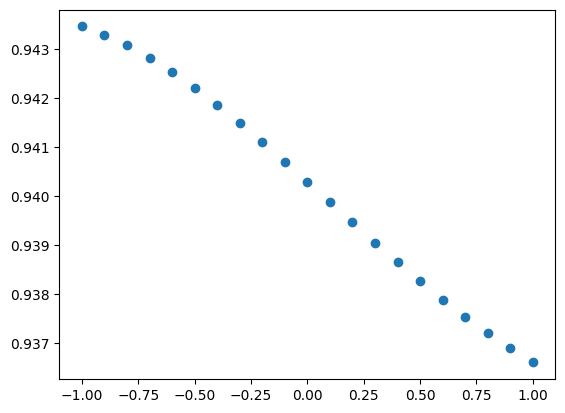

In [104]:
plt.scatter(np.linspace(-1, 1, len(Y_plot)),Y_plot)

In [105]:
Y

[[-0.96],
 [-0.577],
 [-0.073],
 [0.377],
 [0.641],
 [0.66],
 [0.461],
 [0.134],
 [-0.201],
 [-0.434],
 [-0.5],
 [-0.393],
 [-0.165],
 [0.099],
 [0.307],
 [0.396],
 [0.345],
 [0.182],
 [-0.031],
 [-0.219],
 [-0.321]]

epoch: 0 loss: 1.0848613624606123
epoch: 1 loss: 1.0820208879299744
epoch: 2 loss: 1.0760884808024853
epoch: 3 loss: 1.0665200179891223
epoch: 4 loss: 1.052387586105664
epoch: 5 loss: 1.0322205385178358
epoch: 6 loss: 1.0037540383415195
epoch: 7 loss: 0.963572140872847
epoch: 8 loss: 0.9067236507263917
epoch: 9 loss: 0.826743956437483
epoch: 10 loss: 0.7175045277885171


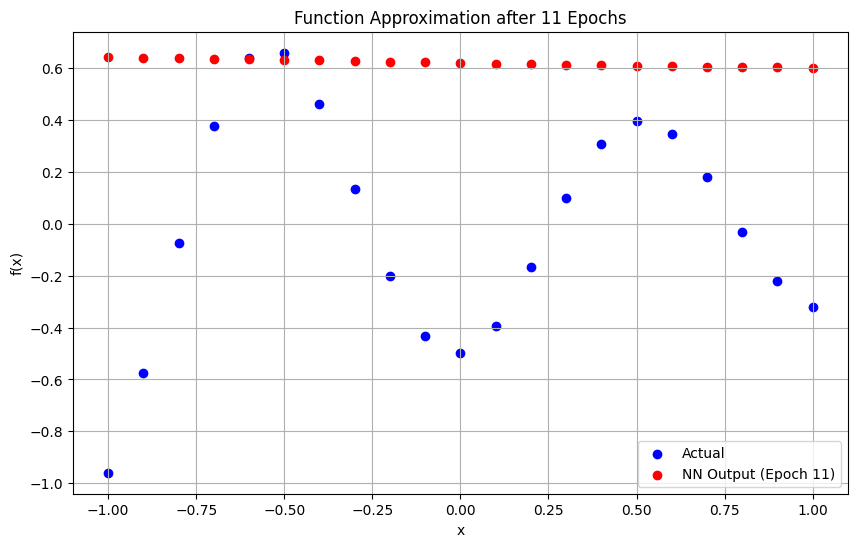

epoch: 11 loss: 0.5797048303350871
epoch: 12 loss: 0.43174268597730714
epoch: 13 loss: 0.30866011096377427
epoch: 14 loss: 0.2333328479856872
epoch: 15 loss: 0.19824320959861289
epoch: 16 loss: 0.18454279357947223
epoch: 17 loss: 0.1795642353052752
epoch: 18 loss: 0.17773439966398358
epoch: 19 loss: 0.17701616326322148
epoch: 20 loss: 0.1767076293141432


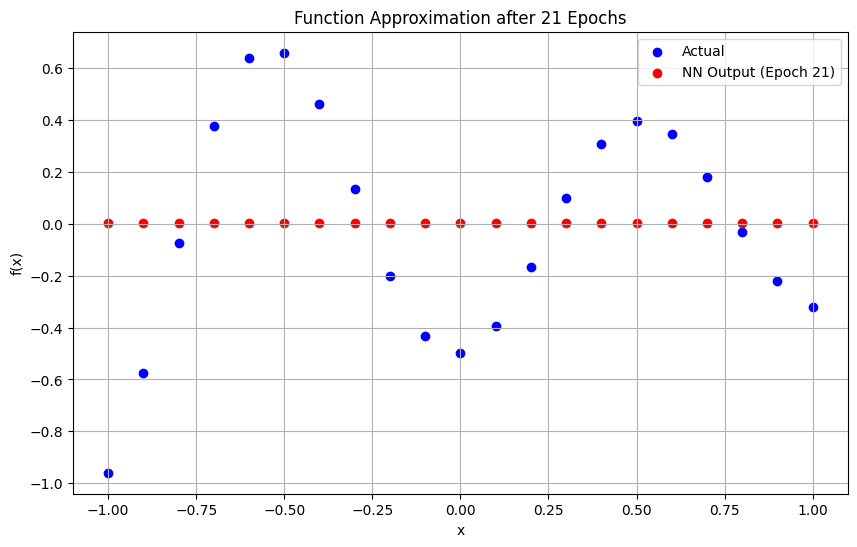

epoch: 21 loss: 0.1765627449187698
epoch: 22 loss: 0.17648952694536038
epoch: 23 loss: 0.17645044049683398
epoch: 24 loss: 0.17642873087470282
epoch: 25 loss: 0.176416316519263
epoch: 26 loss: 0.17640905731283274
epoch: 27 loss: 0.17640473554887265
epoch: 28 loss: 0.1764021234105802
epoch: 29 loss: 0.17640052377020313
epoch: 30 loss: 0.17639953275529266


In [ ]:
for epoch in range(1000):
    y_pred = [nn(x) for x in X]
    loss = MSE(y_pred, Y)
    lossi.append(loss.data)
    print(f'epoch: {epoch} loss: {loss.data}')
    loss.backprop()
    nn.optim()

    if epoch in [10, 20, 99, 199, 399, 999]:
        plt.figure(figsize=(10, 6))
        plt.scatter(X, Y, color='blue', label='Actual')
        
        # X_plot = np.linspace(-1, 1, 100).reshape(-1, 1)
        Y_plot = [nn(x)[0].data for x in X]
        plt.scatter(X, Y_plot, color='red', label=f'NN Output (Epoch {epoch+1})')
        
        plt.title(f'Function Approximation after {epoch+1} Epochs')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
plt.plot(lossi, label='Train Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()